## Exercise with many variables
Hi all, this exercise is unsolved, I haven't figured out how to clean up this, so I am very open to all sort of improvements. 

_The math still constains an error, leading to some unphysical behavior, please forgive me if your pendulum goes crazy._

This exercise is an example of a script I regularly deal with. It has many variables that I define in the beginning. In this case they are:
    - time parameters for the simulation
    - animation parameter
    - simulation parameters
    - initial conditions
    - plotting parameters 

I would like to create a way to swap out configurations quickly. Several ideas I had are in a cell named CONFIG OPTIONS.
The cells has 3 options for creating configurations, using: 
    - dictionary
    - class
    - config.ini file
    
    
# Goal 
Create 2 different pendulum configurations (preferably changing many parameters), that can be interchanged very easily. 
For example, a pendulum with 5 bulbs on the moon (n=5, g= -1.6) and a pendulum with 3 bulbs on earth (n=3, g = -10). 

Also feel free to play around with the animation, or any other part of the code that you find interesting or could use improvement. 


# Note on the animation
In order for the animation to work, you will need ffmpeg. 
You can install it with: 
```conda install -c menpo ffmpeg```


You can also use one of these tutorials: 

https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg 

https://www.wikihow.com/Install-FFmpeg-on-Windows


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import HTML
from matplotlib import animation, rc
from scipy.integrate import odeint  
import configparser

In [2]:
# time parameters
dt = 0.005; 
tLast = 2; 
n_frames = int( tLast/dt )
tInt = np.arange(0,tLast+dt, dt) ;

# animation parameters
fps = 100 

# simulation parameters
n = 3 # number of pendulums 
g = -1  # gravitational constant [m/s^2]
b = 0.01  # damping term 
m = 1* np.ones((n ,1) ) / n  # mass of all the pendulum bulbs
l_vec = np.ones((n ,1) ) /n  # length of pendulum beams

# initial conditions (random position currently) 
y0 = np.zeros( n*2) 
y0[:n] = np.random.rand( n)*np.pi   

# plotting parameters
fig_h = 7
fig_v = 4
window = 1.1  # sets window size 
dot_scale = 500

## CONFIG OPTIONS

In [3]:
# -----Options of storing parameters: a dictionary--------
PEND_DICT = {
    'pendulum_condition': 'inverted start',
    'n'  :3,
    'g': -10,
    'y0': np.hstack( ( np.zeros(n), np.ones(n)*np.pi )  )
}
print('variables obtained from PEND_DICT:',PEND_DICT['n'], PEND_DICT['g'],PEND_DICT['y0'])


# -----Options of storing parameters: a class--------
class PEND_CLASS:
    pendulum_condition ='inverted start'
    n =3
    g = -10 
    y0 = np.zeros(n*2)
    y0[n:n*2] = np.pi
print('variables obtained from PEND_CLASS:',PEND_CLASS.n,PEND_CLASS.g, PEND_CLASS.y0 ) 


# -----Options of storing parameters: a config file--------
# this uses the 'config.ini' file
config = configparser.ConfigParser()
config.read('config.ini')

gc = config.get('INVERTED', 'g')
exec(config.get('INVERTED',  'y0c'  ))
nc = config.get('INVERTED', 'n')
print('variables obtained from config.ini:', nc,gc, y0c )

variables obtained from PEND_DICT: 3 -10 [0.         0.         0.         3.14159265 3.14159265 3.14159265]
variables obtained from PEND_CLASS: 3 -10 [0.         0.         0.         3.14159265 3.14159265 3.14159265]
variables obtained from config.ini: 3 -10 [0.         0.         0.         3.14159265 3.14159265 3.14159265]


In [4]:
# define pendulum dynamics 
def pendulum_dynamics( y,t): 
    dydt =  np.zeros([2*n])  
    M_ij = np.zeros((n,n) )
    C_ij = np.zeros((n,n) )
    S_ij = np.zeros((n,n) ) 
    theta = y[ 0:n]  
    for i in range(n ):
        for j in range(n ): 
            m_max = np.max([i,j])  
            M_ij[i,j] = np.sum(m[m_max:])
            S_ij[i,j] = np.sin(theta[ i]-theta[ j])
            C_ij[i,j] = np.cos(theta[ i]-theta[ j])
    L = np.multiply(l_vec,l_vec.transpose()) 
    M = np.multiply(M_ij, np.multiply( L,C_ij)  )  
    C = np.multiply(M_ij, np.multiply( L,S_ij)  )  
    np.fill_diagonal(C,0)
    K = np.multiply( np.diag(l_vec)*g , M_ij) 
    D = np.diag(np.ones(n))*b 
    dydt[0:n] = y[n:n*2]
    dydt[ n:n*2] = - np.dot(np.linalg.inv(M) , (    np.dot(C,y[ n:n*2]**2) +      # 
                                                np.dot( K, np.sin( y[0:n]) ) +   # 
                                                np.dot(D,y[n:n*2])  )    ) 
    return dydt

# for animation: initialization function to plot the background of each frame
def init():
    line.set_data([], [])
    dots.set_offsets( []  )
    return (line,dots, )

# for animation: update line and scatter plots
def animate(i): 
    x_vec = np.multiply( l_vec[:,0], np.sin(y[i,:n]))
    y_vec = np.multiply( l_vec[:,0], np.cos(y[i,:n]))  
    x_pos = np.array( np.hstack([0, np.cumsum(x_vec)]) )
    y_pos = np.array( np.hstack([0, np.cumsum(y_vec)]))
    line.set_data( x_pos,y_pos ) 
    dots.set_offsets( np.vstack( (x_pos,y_pos )  ).transpose().tolist()  )  
    return (line,dots, ) 

In [5]:
# simulate pendulum dynamics 
y = odeint(pendulum_dynamics, y0, tInt) 

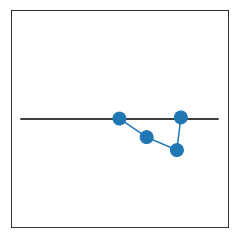

In [6]:
# Create figure and axis
fig = plt.figure(figsize=(fig_h,fig_v))
ax = fig.add_subplot(1, 1, 1)

# find vector of every pendulum, cumulative sum gives the position of every pendulum point 
x_vec = np.multiply( l_vec[:,0], np.sin(y0[:n]))
y_vec = np.multiply( l_vec[:,0], np.cos(y0[:n])) 
x_pos = np.array( np.hstack([0, np.cumsum(x_vec)]) )
y_pos = np.array( np.hstack([0, np.cumsum(y_vec)]))
   
# plot the first window, we will overwrite line and dots 
plt.plot([-1,1],[0,0],'k', zorder = -3) 
line, = plt.plot( x_pos, y_pos ) 
dots  = plt.scatter( x_pos ,y_pos,s=m*dot_scale )

# set plot parameters 
ax.set_xlim( ( np.array([-1.,1.])*window  ))
ax.set_ylim( ( np.array([-1.,1.])*window ))
ax.set_aspect('equal')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the left edge are off
    right=False,         # ticks along the right edge are off
    labelbottom=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

In [7]:
#  call the animator.
anim = animation.FuncAnimation(fig, animate , init_func=init,
                               frames=n_frames ,interval= int( 1000/fps ), blit=True)
HTML(anim.to_html5_video())